In [1]:
import sys
sys.path.insert(0, '../../..')
from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

/home/sharav/src/portfolio-xm/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# loading history with features...
print("reading dataset...")

df = pd.read_csv("../../../data/BTCUSDT/BTCUSDT-features-1m.csv", parse_dates=True, index_col="timestamp")

df

reading dataset...


,op,hi,lo,cl,volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:02:00+00:00,4292.39,4292.39,4292.39,4292.39,0.163824,58.204862,-0.097984,-15.292408,0.730069,70.892627,...,-0.846987,-0.974818,1,-0.417726,0.887136,-3.622000,-9.903640,-1.352286,-0.174593,5.412000
2017-08-18 04:04:00+00:00,4269.26,4269.26,4269.26,4269.26,0.988305,38.387955,-0.440284,-99.185249,0.636822,42.520834,...,-0.999636,-0.687760,0,1.146701,0.880253,16.873143,-13.129643,19.905429,-0.233253,9.252000
2017-08-18 04:05:00+00:00,4269.01,4269.01,4269.01,4269.01,0.557007,38.236424,-0.446114,-100.000000,0.626582,40.226107,...,-0.779648,-0.108492,0,1.000000,0.863521,12.400286,-36.856195,22.145429,-0.749626,11.392851
2017-08-18 04:07:00+00:00,4269.01,4269.01,4269.01,4269.01,0.591960,38.236424,-0.446346,-100.000000,0.682004,40.226107,...,-0.652191,0.074857,0,1.000000,0.808468,4.594286,-56.833464,24.485714,-1.530110,9.327503
2017-08-18 04:08:00+00:00,4269.01,4269.01,4269.01,4269.01,0.339186,38.236424,-0.446346,-100.000000,0.650170,37.361274,...,-0.694225,0.018055,0,1.000000,0.758373,1.512571,-60.862617,24.833143,-1.793890,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10 03:59:00+00:00,19451.27,19453.96,19450.38,19452.99,21.652750,56.802230,0.071917,-8.819658,0.122910,71.095889,...,0.607934,-0.131559,0,1.784075,0.837175,1.696571,47.658417,-12.569429,1.097385,1.399807
2022-10-10 04:00:00+00:00,19452.97,19452.99,19441.06,19444.70,134.439800,46.282289,0.003343,-56.008700,0.073632,56.540301,...,0.401330,-0.363880,0,2.713026,0.810902,7.940857,35.492626,-1.329429,0.713099,3.236260
2022-10-10 04:01:00+00:00,19443.89,19448.31,19441.93,19442.37,50.338190,43.825537,-0.025608,-70.835670,0.057582,50.091731,...,0.307295,-0.455602,0,-0.272117,0.782850,7.536571,14.333334,4.214857,0.255516,4.648739


In [3]:
# Helper functions

def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['hi']+df_['lo']+df_['cl'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [4]:
# CCI signal extraction

timeframe = 5

d = {
    'op'    : 'first', 
    'hi'    : 'max'  ,
    'lo'    : 'min'  ,
    'cl'    : 'last' ,
    'volume': 'sum'
    }
df_xm = df.resample(f"{timeframe}Min").agg(d)

df_xm['cci'], _ = cci_indicator(df_xm)
df_xm.dropna(inplace=True)

upper_threshold =  232.4135
lower_threshold = -232.4135

df_xm['position'] = 0
df_xm.loc[(df_xm['cci'].shift(1)<upper_threshold)&(df_xm['cci']>=upper_threshold), 'position'] = -1
df_xm.loc[(df_xm['cci'].shift(1)>lower_threshold)&(df_xm['cci']<=lower_threshold), 'position'] =  1

# saving signals to market state
df['position'] = 0
for idx, row in df_xm[(df_xm['position']==1)|(df_xm['position']==-1)].iterrows():
    if idx in df.index:
        df.loc[idx, 'position'] = row.position

# removing look-ahead bias by lagging signal
df['position'] = df['position'].shift(timeframe+1)

df.dropna(inplace=True)

In [5]:
df['position'].value_counts()

 0.0    2660497
 1.0       4160
-1.0       3784
Name: position, dtype: int64

In [6]:
import joblib

short_features = open("../model/features_short.txt", 'r').read().strip().split()
long_features  = open("../model/features_long.txt" , "r").read().strip().split()

short_rf = joblib.load("../model/btcusdt_rf_short.save")
long_rf  = joblib.load("../model/btcusdt_rf_long.save" )

In [7]:
feature_columns = list(dict.fromkeys(short_features+long_features+["position", "op", "hi", "lo", "cl", "volume"]))
print(feature_columns, len(feature_columns))

['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi', 't_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3', 'position', 'op', 'hi', 'lo', 'cl', 'volume'] 34


In [8]:
len(df.columns)

273

In [12]:
len(feature_columns)

34

In [13]:
len(df[feature_columns].columns)

34

In [14]:
filtered_df = df[feature_columns]

len(filtered_df.columns)

34

In [15]:
# from here we starting to show symptom of the columns duplication
print(list(filtered_df.columns))

['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi', 't_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3', 'position', 'op', 'hi', 'lo', 'cl', 'volume']


In [16]:
print(len(filtered_df.columns))

34


In [17]:
train_df = filtered_df[:"2022-02-02"]
test_df  = filtered_df["2022-02-04":]

In [18]:
# Daily volatility calculation which is helpful for defining tp and sl levels

w = 840 # 14 hours
train_df[f'volatility_tpsl'] = fml.util.get_daily_vol(close=train_df['cl'], lookback=w)
test_df [f'volatility_tpsl'] = fml.util.get_daily_vol(close=test_df ['cl'], lookback=w)

In [19]:
# remove nans
train_df.dropna(inplace=True)
test_df.dropna (inplace=True)

In [20]:
short_features

['vl_atr_12',
 'ma_25',
 't_trix_300',
 'm_roc_180',
 'vl_atr_90',
 'm_rsi_300',
 'LINEARREG_INTERCEPT',
 't_macd_12_6',
 'm_roc_300',
 'vm_fi']

In [21]:
long_features

['t_adx_400',
 't_trix_120',
 'close_sign',
 'daily_volatility_30',
 'vm_mfi_300',
 'm_roc_300',
 'close_plus_minus_20',
 't_dpo_25',
 't_trix_6',
 't_dpo_300',
 'momentum_2',
 't_macd_360_180',
 'log_lag_6',
 'm_wr_400',
 't_dpo_50',
 'MFI',
 'HT_SINE_leadsine',
 'vl_bbp_400',
 'log_lag_3']

In [58]:
# from here we starting to show symptom of the columns duplication
print(list(filtered_df.columns))

['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi', 't_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3', 'position', 'op', 'hi', 'lo', 'cl', 'volume']


In [59]:
print(len(filtered_df.columns))

34


In [60]:
filtered_df['m_roc_300']

timestamp
2017-08-18 04:11:00+00:00   -1.632783
2017-08-18 04:12:00+00:00   -1.610099
2017-08-18 04:13:00+00:00   -1.968239
2017-08-18 04:14:00+00:00   -1.649199
2017-08-18 04:16:00+00:00   -1.946785
                               ...   
2022-10-10 03:59:00+00:00    0.284207
2022-10-10 04:00:00+00:00    0.350057
2022-10-10 04:01:00+00:00    0.268226
2022-10-10 04:02:00+00:00    0.216403
2022-10-10 04:03:00+00:00    0.159032
Name: m_roc_300, Length: 2668441, dtype: float64

In [61]:
train_df = filtered_df[:"2022-02-02"].copy(deep=True)
test_df  = filtered_df["2022-02-04":].copy(deep=True)

In [62]:
# Daily volatility calculation which is helpful for defining tp and sl levels

w = 840 # 14 hours
train_df[f'volatility_tpsl'] = fml.util.get_daily_vol(close=train_df['cl'], lookback=w)
test_df [f'volatility_tpsl'] = fml.util.get_daily_vol(close=test_df ['cl'], lookback=w)

In [63]:
# remove nans
train_df.dropna(inplace=True)
test_df.dropna (inplace=True)

In [64]:
len(train_df.columns), len(list(dict.fromkeys(train_df.columns)))

(35, 35)

In [65]:
len(test_df.columns), len(list(dict.fromkeys(test_df.columns)))

(35, 35)

In [69]:
from backtesting     import Backtest, Strategy
from backtesting.lib import crossover

In [71]:
eval_feature_columns = list(dict.fromkeys(short_features+long_features+["position", "volatility_tpsl", "Open", "High", "Low", "Close", "Volume"]))

list(eval_feature_columns), len(eval_feature_columns)

(['vl_atr_12',
  'ma_25',
  't_trix_300',
  'm_roc_180',
  'vl_atr_90',
  'm_rsi_300',
  'LINEARREG_INTERCEPT',
  't_macd_12_6',
  'm_roc_300',
  'vm_fi',
  't_adx_400',
  't_trix_120',
  'close_sign',
  'daily_volatility_30',
  'vm_mfi_300',
  'close_plus_minus_20',
  't_dpo_25',
  't_trix_6',
  't_dpo_300',
  'momentum_2',
  't_macd_360_180',
  'log_lag_6',
  'm_wr_400',
  't_dpo_50',
  'MFI',
  'HT_SINE_leadsine',
  'vl_bbp_400',
  'log_lag_3',
  'position',
  'volatility_tpsl',
  'Open',
  'High',
  'Low',
  'Close',
  'Volume'],
 35)

In [72]:
test_df = test_df.rename(columns={
    "op"    : "Open" ,
    "hi"    : "High" ,
    "lo"    : "Low"  ,
    "cl"    : "Close",
    "volume": "Volume"
    })

test_df = test_df[eval_feature_columns]

test_df

,vl_atr_12,ma_25,t_trix_300,m_roc_180,vl_atr_90,m_rsi_300,LINEARREG_INTERCEPT,t_macd_12_6,m_roc_300,vm_fi,...,HT_SINE_leadsine,vl_bbp_400,log_lag_3,position,volatility_tpsl,Open,High,Low,Close,Volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-05 00:02:00+00:00,94.282315,0.004671,0.009464,2.149254,49.936652,58.420259,106.539429,-57.915568,2.397082,2316.588428,...,-0.864366,1.458472,0.000802,0.0,0.000062,41452.83,41487.41,41392.60,41441.84,139.24445
2022-02-05 00:03:00+00:00,92.956289,0.002526,0.009452,2.078533,50.252578,57.975842,230.865143,-62.506207,2.322774,1594.041005,...,-0.920715,1.375612,-0.001374,0.0,0.001761,41434.98,41442.26,41363.89,41379.33,43.85288
2022-02-05 00:04:00+00:00,89.784098,0.001923,0.009441,2.137364,50.304105,57.980972,281.128571,-60.055678,2.376917,1375.992412,...,-0.964284,1.362380,-0.001551,0.0,0.001683,41379.33,41397.87,41342.98,41380.33,67.70085
2022-02-05 00:05:00+00:00,88.108756,0.002764,0.009430,2.278603,50.519392,58.300329,204.370286,-47.462705,2.525912,1736.751338,...,-0.991107,1.412329,-0.000265,0.0,0.001565,41380.32,41450.00,41380.32,41442.85,62.40091
2022-02-05 00:06:00+00:00,86.204693,0.001876,0.009419,2.338163,50.683177,58.231292,212.041714,-38.608559,2.540196,1422.135876,...,-0.996875,1.386334,-0.001510,0.0,0.001426,41442.84,41449.27,41384.01,41433.13,47.89680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10 03:59:00+00:00,7.324722,0.000561,-0.000014,-0.197164,9.734449,49.647324,-12.569429,0.464567,0.284207,17.786588,...,-0.131559,0.495835,0.000065,0.0,0.003802,19451.27,19453.96,19450.38,19452.99,21.65275
2022-10-10 04:00:00+00:00,7.708495,0.000131,-0.000014,-0.331022,9.758844,49.352064,-1.329429,-0.627056,0.350057,-143.969488,...,-0.363880,0.435294,0.000138,0.0,0.003799,19452.97,19452.99,19441.06,19444.70,134.43980
2022-10-10 04:01:00+00:00,7.597787,-0.000002,-0.000013,-0.284493,9.721301,49.269434,4.214857,-1.391910,0.268226,-140.157844,...,-0.455602,0.418511,-0.000137,0.0,0.003795,19443.89,19448.31,19441.93,19442.37,50.33819


In [73]:
test_df['m_roc_300']

timestamp
2022-02-05 00:02:00+00:00    2.397082
2022-02-05 00:03:00+00:00    2.322774
2022-02-05 00:04:00+00:00    2.376917
2022-02-05 00:05:00+00:00    2.525912
2022-02-05 00:06:00+00:00    2.540196
                               ...   
2022-10-10 03:59:00+00:00    0.284207
2022-10-10 04:00:00+00:00    0.350057
2022-10-10 04:01:00+00:00    0.268226
2022-10-10 04:02:00+00:00    0.216403
2022-10-10 04:03:00+00:00    0.159032
Name: m_roc_300, Length: 355922, dtype: float64

In [74]:
train_df = train_df.rename(columns={
    "op"    : "Open" ,
    "hi"    : "High" ,
    "lo"    : "Low"  ,
    "cl"    : "Close",
    "volume": "Volume"
    })

train_df = train_df[eval_feature_columns]

train_df

,vl_atr_12,ma_25,t_trix_300,m_roc_180,vl_atr_90,m_rsi_300,LINEARREG_INTERCEPT,t_macd_12_6,m_roc_300,vm_fi,...,HT_SINE_leadsine,vl_bbp_400,log_lag_3,position,volatility_tpsl,Open,High,Low,Close,Volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-19 04:27:00+00:00,13.920243,0.002520,-0.000530,-0.023815,5.967966,50.520818,9.910000,-2.287238,0.887989,-17.096747,...,-0.471114,0.660717,0.000000,0.0,0.013528,4105.38,4156.00,4105.38,4156.00,1.002484
2017-08-19 04:29:00+00:00,14.890204,-0.003838,-0.000499,-0.649268,6.261860,49.589822,26.953429,1.777923,0.256832,-13.470285,...,-0.480099,0.521180,0.000000,0.0,0.009763,4117.68,4130.00,4117.68,4130.00,0.244841
2017-08-19 04:30:00+00:00,13.649354,-0.003756,-0.000484,-0.649268,6.192283,49.589822,23.218000,1.445059,0.256832,-11.545958,...,-0.379057,0.519278,0.019282,0.0,0.008048,4130.00,4130.00,4130.00,4130.00,0.065220
2017-08-19 04:32:00+00:00,11.469249,-0.003256,-0.000454,-1.306671,6.055441,49.589822,13.518571,1.161736,0.256832,-8.482745,...,-0.203495,0.515414,-0.006276,0.0,0.006989,4130.00,4130.00,4130.00,4130.00,0.009391
2017-08-19 04:35:00+00:00,14.837575,-0.019222,-0.000412,-3.028189,6.656272,47.134451,79.671143,-6.578643,-1.515865,-15.674508,...,0.391059,0.089980,0.000000,0.0,0.009505,4105.38,4105.38,4057.96,4057.96,1.004001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-02 23:55:00+00:00,47.283322,-0.000219,-0.004586,-2.009920,51.090063,46.402149,-0.273143,0.679094,-1.523685,41.147864,...,0.381278,0.129182,-0.000650,0.0,0.019352,36836.13,36882.93,36824.48,36881.32,32.432020
2022-02-02 23:56:00+00:00,45.110545,0.000172,-0.004588,-1.849072,50.758062,46.496128,-9.240571,4.489998,-1.442700,87.472462,...,-0.860522,0.143543,-0.000805,0.0,0.019356,36877.68,36898.89,36877.68,36894.60,27.516570
2022-02-02 23:57:00+00:00,48.575500,0.001332,-0.004590,-1.770877,51.157306,46.775064,-54.818857,10.243271,-1.372459,316.696586,...,-0.591786,0.181901,-0.000051,0.0,0.019357,36894.61,36974.98,36888.29,36934.16,42.771520


In [75]:
train_df['m_roc_300']

timestamp
2017-08-19 04:27:00+00:00    0.887989
2017-08-19 04:29:00+00:00    0.256832
2017-08-19 04:30:00+00:00    0.256832
2017-08-19 04:32:00+00:00    0.256832
2017-08-19 04:35:00+00:00   -1.515865
                               ...   
2022-02-02 23:55:00+00:00   -1.523685
2022-02-02 23:56:00+00:00   -1.442700
2022-02-02 23:57:00+00:00   -1.372459
2022-02-02 23:58:00+00:00   -1.531324
2022-02-02 23:59:00+00:00   -1.574063
Name: m_roc_300, Length: 2308734, dtype: float64

In [76]:
len(train_df.columns), len(test_df.columns)

(35, 35)

In [77]:
# Model performance evaluation on OOS data

pt_sl = [0.7, 0.7]

binance_commission = 0.001

long_trigger_threshold  = 0.55
long_green_threshold    = 0.6

short_trigger_threshold = 0.55
short_green_threshold   = 0.6

class CCIMetaStrategy(Strategy):
    long_model  = None
    short_model = None
    def init(self):
        super().init()
    def next(self):
        super().next()

        if self.long_model is None:
            print("please supply long side model...")
            return
        if self.short_model is None:
            print("please supply short side model...")
            return

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        price      = self.data.Close[-1]
        volatility = self.data.volatility_tpsl[-1]

        short_state = []
        for feature in short_features:
            short_state.append(self.data[feature][-1])

        long_state = []
        for feature in long_features:
            long_state.append(self.data[feature][-1])

        # Long case
        if self.long_model is not None and self.data.position[-1]==1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[0])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[1])
            probability = self.long_model.predict_proba([long_state])[0,1]
            size = 1.0
            if probability>=long_trigger_threshold and probability<long_green_threshold:
                size = 0.5
            if probability>=long_green_threshold:
                size=1.0
            if probability>=long_trigger_threshold:
                self.buy(size=size, sl=price_1, tp=price_0)

        # Short case
        if self.short_model is not None and self.data.position[-1]==-1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[1])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[0])

            probability = self.short_model.predict_proba([short_state])[0,1]
            size = 1.0
            if probability>=short_trigger_threshold and probability<short_green_threshold:
                size = 0.5
            if probability>=short_green_threshold:
                size=1.0
            if probability>=short_trigger_threshold:
                self.sell(size=size, sl=price_0, tp=price_1)

bt = Backtest(
    test_df, 
    CCIMetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run(long_model=long_rf, short_model=short_rf)

print(stats)

Start                     2022-02-05 00:02...
End                       2022-10-10 04:03...
Duration                    247 days 04:01:00
Exposure Time [%]                   20.962177
Equity Final [$]               94581476.72574
Equity Peak [$]               101005627.87623
Return [%]                          -5.418523
Buy & Hold Return [%]              -53.085939
Return (Ann.) [%]                   -8.760874
Volatility (Ann.) [%]                8.622038
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -6.948354
Avg. Drawdown [%]                   -0.166094
Max. Drawdown Duration      239 days 11:13:00
Avg. Drawdown Duration        4 days 06:20:00
# Trades                                  275
Win Rate [%]                        52.363636
Best Trade [%]                       3.963728
Worst Trade [%]                     -3.604795
Avg. Trade [%]                    

Start date,2022-02-05
End date,2022-10-09
Total months,13
,Backtest
Annual return,-5.7%
Cumulative returns,-6.2%
Annual volatility,18.6%
Sharpe ratio,-0.22
Calmar ratio,-0.39
Stability,0.58
Max drawdown,-14.9%


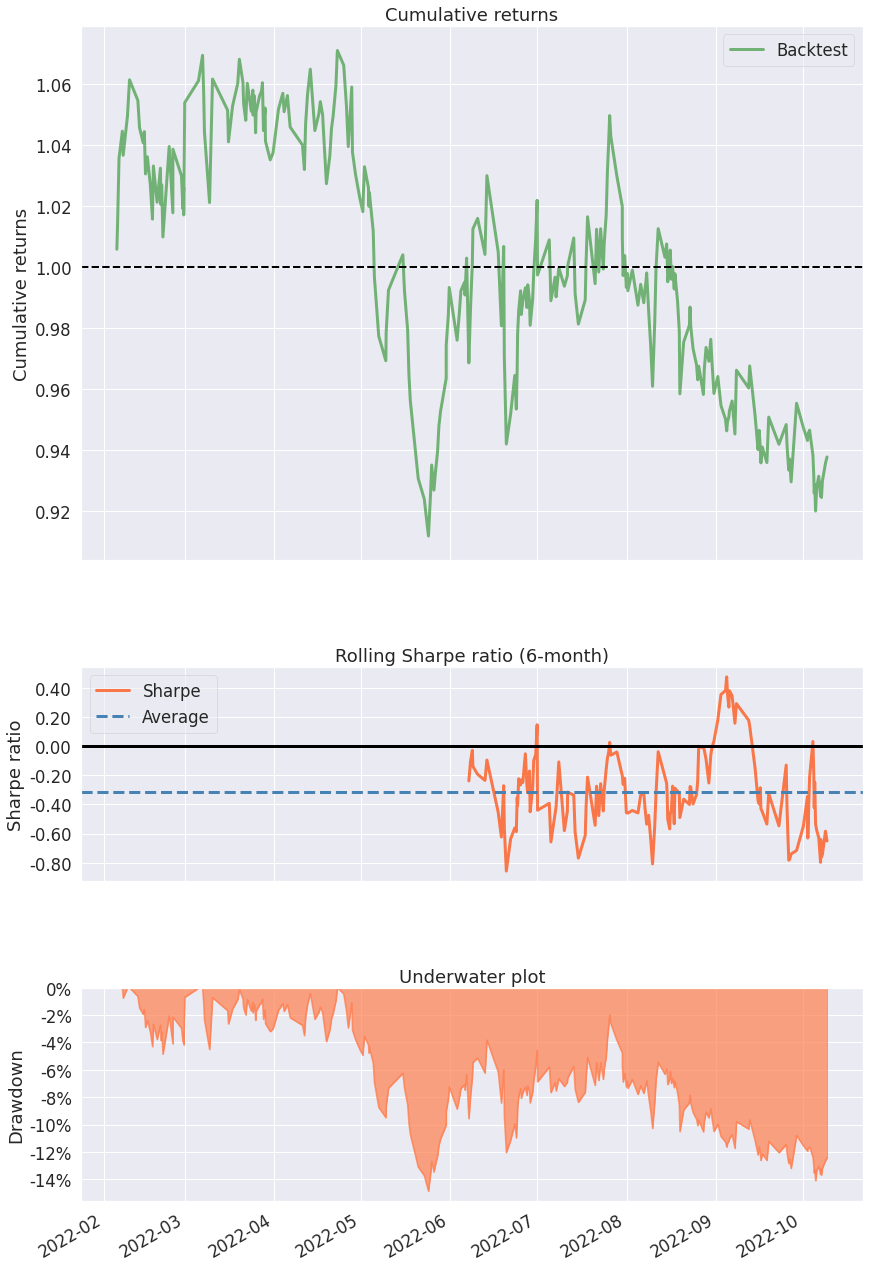

In [78]:
stat_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stat_df = stat_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stat_df['ReturnPct'])

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

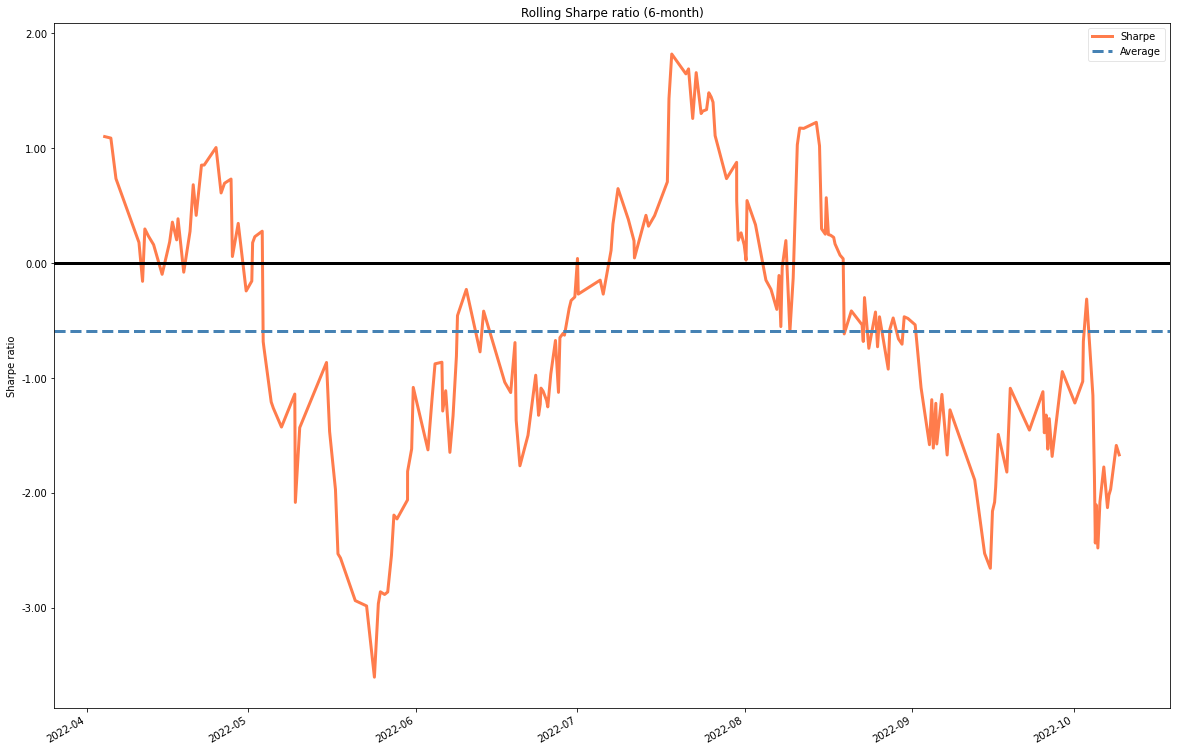

In [79]:
from pyfolio.plotting import plot_rolling_sharpe

plt.figure(figsize=(20, 14))
plot_rolling_sharpe(stat_df['ReturnPct'], rolling_window=21*3)

In [80]:
train_df['m_roc_300']

timestamp
2017-08-19 04:27:00+00:00    0.887989
2017-08-19 04:29:00+00:00    0.256832
2017-08-19 04:30:00+00:00    0.256832
2017-08-19 04:32:00+00:00    0.256832
2017-08-19 04:35:00+00:00   -1.515865
                               ...   
2022-02-02 23:55:00+00:00   -1.523685
2022-02-02 23:56:00+00:00   -1.442700
2022-02-02 23:57:00+00:00   -1.372459
2022-02-02 23:58:00+00:00   -1.531324
2022-02-02 23:59:00+00:00   -1.574063
Name: m_roc_300, Length: 2308734, dtype: float64

In [81]:
train_sides             = train_df[(train_df['position']==1)|(train_df['position']==-1)]['position']
train_signal_indexes    = train_df[(train_df['position']==1)|(train_df['position']==-1)].index
train_vertical_barriers = fml.labeling.add_vertical_barrier(t_events=train_signal_indexes, close=train_df['Close'], num_days=2)

pt_sl   = [0.7, 0.7]
min_ret = 0.001
train_triple_barriers = fml.labeling.get_events(
    close                  = train_df['Close'],
    t_events               = train_signal_indexes,
    pt_sl                  = pt_sl,
    target                 = train_df['volatility_tpsl'],
    min_ret                = min_ret,
    num_threads            = 1,
    vertical_barrier_times = train_vertical_barriers,
    side_prediction        = train_sides
    )

train_labels = fml.labeling.get_bins(train_triple_barriers, train_df['Close'])

In [82]:
train_triple_barriers

,t1,trgt,side,pt,sl
timestamp,,,,,
2017-08-22 09:43:00+00:00,2017-08-22 14:31:00+00:00,0.030959,-1.0,0.7,0.7
2017-08-22 12:36:00+00:00,2017-08-22 12:55:00+00:00,0.026212,-1.0,0.7,0.7
2017-08-22 13:01:00+00:00,2017-08-22 13:33:00+00:00,0.026296,-1.0,0.7,0.7
2017-08-24 12:31:00+00:00,2017-08-24 14:35:00+00:00,0.027846,1.0,0.7,0.7
2017-08-25 03:17:00+00:00,2017-08-25 15:17:00+00:00,0.022542,1.0,0.7,0.7
...,...,...,...,...,...
2022-02-02 00:41:00+00:00,2022-02-02 14:33:00+00:00,0.014294,1.0,0.7,0.7
2022-02-02 12:16:00+00:00,2022-02-02 13:50:00+00:00,0.009334,-1.0,0.7,0.7
2022-02-02 12:51:00+00:00,2022-02-02 13:49:00+00:00,0.009010,-1.0,0.7,0.7


In [83]:
train_labels

,ret,trgt,bin,side
timestamp,,,,
2017-08-22 09:43:00+00:00,0.032127,0.030959,1,-1.0
2017-08-22 12:36:00+00:00,-0.021501,0.026212,0,-1.0
2017-08-22 13:01:00+00:00,0.020078,0.026296,1,-1.0
2017-08-24 12:31:00+00:00,0.019681,0.027846,1,1.0
2017-08-25 03:17:00+00:00,0.015806,0.022542,1,1.0
...,...,...,...,...
2022-02-02 00:41:00+00:00,-0.015451,0.014294,0,1.0
2022-02-02 12:16:00+00:00,0.007757,0.009334,1,-1.0
2022-02-02 12:51:00+00:00,0.006372,0.009010,1,-1.0


In [84]:
# combinatorial purged cross validation and warm them up

X_train = df.loc[train_labels.index]
y_train = train_labels['bin']

n_split      = 10
n_test_split = 2

info_sets = train_triple_barriers.loc[X_train.index].t1

cv_gen = fml.cross_validation.CombinatorialPurgedKFold(
    n_splits          = n_split,
    n_test_splits     = n_test_split,
    samples_info_sets = info_sets,
    pct_embargo       = 0.01
)

# warmup for path information
for train_idxs, test_idxs in cv_gen.split(X=X_train, y=y_train):
    pass

print(f"total paths : {len(cv_gen.backtest_paths)}")

total paths : 9


In [85]:
# Analyzing average testing periods by weeks

dt_list = []

for cv_path_set in cv_gen.backtest_paths:
    for cv_path in cv_path_set:
        test_dates = []
        for test_idx in cv_path['test']:
            test_dates.append(info_sets.iloc[test_idx])
        test_min_date = pd.to_datetime(min(test_dates))
        test_max_date = pd.to_datetime(max(test_dates))

        delta_time = pd.Timedelta(test_max_date - test_min_date)
        dt_list.append(int(delta_time.days/7))
        print(f"{delta_time} {int(delta_time.days/7)} weeks")

dt_list = np.array(dt_list)
dt_df   = pd.DataFrame()
dt_df['dt'] = dt_list

221 days 18:38:00 31 weeks
141 days 09:40:00 20 weeks
143 days 10:48:00 20 weeks
152 days 15:31:00 21 weeks
153 days 19:53:00 21 weeks
150 days 03:58:00 21 weeks
157 days 17:02:00 22 weeks
167 days 17:16:00 23 weeks
171 days 11:08:00 24 weeks
164 days 11:15:00 23 weeks
221 days 18:38:00 31 weeks
141 days 09:40:00 20 weeks
143 days 10:48:00 20 weeks
152 days 15:31:00 21 weeks
153 days 19:53:00 21 weeks
150 days 03:58:00 21 weeks
157 days 17:02:00 22 weeks
167 days 17:16:00 23 weeks
171 days 11:08:00 24 weeks
164 days 11:15:00 23 weeks
221 days 18:38:00 31 weeks
141 days 09:40:00 20 weeks
143 days 10:48:00 20 weeks
152 days 15:31:00 21 weeks
153 days 19:53:00 21 weeks
150 days 03:58:00 21 weeks
157 days 17:02:00 22 weeks
167 days 17:16:00 23 weeks
171 days 11:08:00 24 weeks
164 days 11:15:00 23 weeks
221 days 18:38:00 31 weeks
141 days 09:40:00 20 weeks
143 days 10:48:00 20 weeks
152 days 15:31:00 21 weeks
153 days 19:53:00 21 weeks
150 days 03:58:00 21 weeks
157 days 17:02:00 22 weeks
1

<AxesSubplot:>

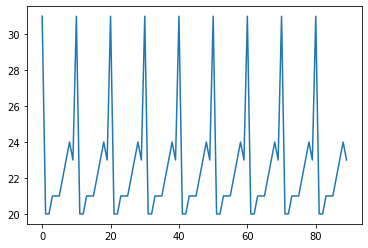

In [86]:
dt_df['dt'].plot()

In [87]:
X_train.loc[info_sets.index]

,op,hi,lo,cl,volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,position
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-22 09:43:00+00:00,3884.55,3920.31,3884.55,3908.47,3.901092,67.276357,0.852290,-20.911339,0.703280,76.152930,...,-0.598373,1,0.521973,0.847649,11.114857,75.754372,-40.089143,3.938769,6.586488,-1.0
2017-08-22 12:36:00+00:00,3923.25,3923.25,3904.33,3904.33,0.900936,55.712959,0.768605,-50.149651,0.006332,74.614280,...,-0.636469,1,0.498311,0.851365,19.550000,73.250528,-23.645714,3.322747,9.271319,-1.0
2017-08-22 13:01:00+00:00,3934.01,3952.14,3934.01,3952.14,0.304733,54.478750,-0.196721,-46.041944,-0.008849,67.970142,...,0.274143,0,0.148940,0.765347,-5.405714,52.747445,-22.500000,1.314945,15.113791,-1.0
2017-08-24 12:31:00+00:00,4136.58,4136.58,4136.58,4136.58,0.186715,35.981794,-0.730022,-99.503574,-0.119196,42.840622,...,0.627501,1,1.000072,0.981233,8.070571,-69.445921,42.740857,-2.666945,10.553783,1.0
2017-08-25 03:17:00+00:00,4335.00,4335.00,4295.81,4295.81,0.575836,34.630016,-1.115948,-99.896971,0.001878,54.867211,...,0.803700,1,-0.039367,0.904401,-5.561714,-73.255965,37.648857,-3.323890,2.064980,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-02 00:41:00+00:00,38453.46,38525.71,38453.46,38490.70,22.397080,29.356660,-0.679773,-84.082286,-0.375168,14.844968,...,0.718264,1,0.278151,0.989060,-82.556000,-87.630919,231.667429,-24.171033,12.787679,1.0
2022-02-02 12:16:00+00:00,38674.91,38681.00,38652.11,38656.53,12.720950,68.691602,0.311341,-13.882113,0.445962,90.411012,...,-0.752974,1,1.129805,0.964002,27.805143,85.539599,-138.848000,12.819473,13.943053,-1.0
2022-02-02 12:51:00+00:00,38692.92,38695.65,38647.50,38651.65,23.345070,49.959155,0.108081,-69.013206,-0.059088,68.184444,...,-0.902371,1,0.379053,0.951611,61.259143,80.501259,-16.436286,5.976571,23.676476,-1.0


In [88]:
y_train[info_sets.index]

timestamp
2017-08-22 09:43:00+00:00    1
2017-08-22 12:36:00+00:00    0
2017-08-22 13:01:00+00:00    1
2017-08-24 12:31:00+00:00    1
2017-08-25 03:17:00+00:00    1
                            ..
2022-02-02 00:41:00+00:00    0
2022-02-02 12:16:00+00:00    1
2022-02-02 12:51:00+00:00    1
2022-02-02 14:36:00+00:00    0
2022-02-02 21:26:00+00:00    0
Name: bin, Length: 6859, dtype: int64

In [89]:
X_train.loc[info_sets.index]['m_roc_300']

timestamp
2017-08-22 09:43:00+00:00    5.760379
2017-08-22 12:36:00+00:00    3.000860
2017-08-22 13:01:00+00:00    4.873305
2017-08-24 12:31:00+00:00   -0.846141
2017-08-25 03:17:00+00:00    1.771123
                               ...   
2022-02-02 00:41:00+00:00    0.326884
2022-02-02 12:16:00+00:00    0.899906
2022-02-02 12:51:00+00:00    1.153149
2022-02-02 14:36:00+00:00   -1.426127
2022-02-02 21:26:00+00:00   -0.090920
Name: m_roc_300, Length: 6859, dtype: float64

In [90]:
# Annualized Sharpe Ratio
def annualized_sharpe_ratio(returns, periods=252):
    estimated_sharpe_ratio = returns.mean()/returns.std(ddof=1)
    return estimated_sharpe_ratio*np.sqrt(periods)

In [91]:
print(len(long_features), " ===> ", long_features)

19  ===>  ['t_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'm_roc_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3']


In [92]:
print(len(short_features), " ===> ", short_features)

10  ===>  ['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi']


In [94]:
for cv_path_set in cv_gen.backtest_paths:
    for cv_path in cv_path_set:
        temp_train_df = X_train.loc[info_sets.index[cv_path['train']]][long_features]
        print(temp_train_df.values.shape)

        temp_train_df = X_train.loc[info_sets.index[cv_path['train']]][short_features]
        print(temp_train_df.values.shape)

        #for col_name in temp_train_df.columns:
        #    print(temp_train_df[col_name])
        #print(temp_train_df.columns)
        #print(temp_train_df['t_adx_400'])
        #temp_df = pd.DataFrame()
        #print(temp_train_df)
        break
    break

#for cv_path_set in cv_gen.backtest_paths:
#    for cv_path in cv_path_set:
#        print(X_train.loc[info_sets.index[cv_path['train']]][short_features].columns)
#        break

(5421, 19)
(5421, 10)


In [95]:
import random
from mlfinlab.sample_weights import get_weights_by_return
from sklearn.ensemble        import RandomForestClassifier

In [96]:
print(long_features , len(long_features))
print(short_features, len(short_features))

['t_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'm_roc_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3'] 19
['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi'] 10


In [97]:
print(train_df.columns)
print(train_df[long_features ].values.shape)
print(train_df[short_features].values.shape)

Index(['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90',
       'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi',
       't_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30',
       'vm_mfi_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6',
       't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400',
       't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3',
       'position', 'volatility_tpsl', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')
(2308734, 19)
(2308734, 10)


In [98]:
test_df['m_roc_300']

timestamp
2022-02-05 00:02:00+00:00    2.397082
2022-02-05 00:03:00+00:00    2.322774
2022-02-05 00:04:00+00:00    2.376917
2022-02-05 00:05:00+00:00    2.525912
2022-02-05 00:06:00+00:00    2.540196
                               ...   
2022-10-10 03:59:00+00:00    0.284207
2022-10-10 04:00:00+00:00    0.350057
2022-10-10 04:01:00+00:00    0.268226
2022-10-10 04:02:00+00:00    0.216403
2022-10-10 04:03:00+00:00    0.159032
Name: m_roc_300, Length: 355922, dtype: float64

In [99]:
# Sharpe Ratio collections from testing paths

pt_sl = [0.7, 0.7]

binance_commission = 0.001

long_trigger_threshold  = 0.52
long_green_threshold    = 0.6

short_trigger_threshold = 0.52
short_green_threshold   = 0.6

class CCIMetaStrategy(Strategy):
    model_long  = None
    model_short = None
    def init(self):
        super().init()
    def next(self):
        super().next()

        if self.model_long is None:
            print("Need to supply long side Random Forest model...")
            return
        if self.model_short is None:
            print("Need to supply short side Random Forest model...")
            return

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        price      = self.data.Close[-1]
        volatility = self.data.volatility_tpsl[-1]

        short_state = []
        for feature in short_features:
            short_state.append(self.data[feature][-1])
        print(f"short state length {len(short_state)}")

        long_state = []
        for feature in long_features:
            long_state.append(self.data[feature][-1])
        print(f"long state length {len(long_state)}")

        # Long case
        if self.model_long is not None and self.data.position[-1]==1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[0])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[1])
            probability = self.model_long.predict_proba([long_state])[0,1]
            size = 1.0
            if probability>=long_trigger_threshold and probability<long_green_threshold:
                size = 0.5
            if probability>=long_green_threshold:
                size=1.0
            if probability>=long_trigger_threshold:
                self.buy(size=size, sl=price_1, tp=price_0)

        # Short case
        if self.model_short is not None and self.data.position[-1]==-1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[1])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[0])

            probability = self.model_short.predict_proba([short_state])[0,1]
            size = 1.0
            if probability>=short_trigger_threshold and probability<short_green_threshold:
                size = 0.5
            if probability>=short_green_threshold:
                size=1.0
            if probability>=short_trigger_threshold:
                self.sell(size=size, sl=price_0, tp=price_1)


sharpe_ratio_list = []

for cv_path_set in cv_gen.backtest_paths:
    for cv_path in cv_path_set:
        #train_dates = []
        #for train_idx in cv_path['train']:
        #    train_dates.append(info_sets.iloc[train_idx])

        # Sample weights
        #sample_weights = get_weights_by_return(
        #    train_triple_barriers.loc[X_train.index], 
        #    train_df.loc[X_train.index, 'Close'],
        #    num_threads=1)

        # train long side model ...
        print("training long sided model...")
        X_train_long = X_train.loc[info_sets.index[cv_path['train']]]
        X_train_long = X_train_long[X_train_long['position']==1][long_features]
        y_train_long = y_train[X_train_long.index]

        print(long_features, len(long_features))
        print(list(X_train_long.columns))
        #print(X_train_long.values.shape)
        #print(X_train_long)

        """
        rf_long = RandomForestClassifier(
            max_depth     = 80                  , 
            n_estimators  = 2500                ,
            criterion     = 'entropy'           , 
            class_weight  = 'balanced_subsample',
            random_state  = 42                  ,
            n_jobs        = -1
        )
        print(f"long features length {len(long_features)}")
        rf_long.fit(
            X_train_[long_features], 
            y_train_,
            #sample_weight=sample_weights
        )
        """

        # train short side model ...
        print("training short sided model...")
        X_train_short = X_train.loc[info_sets.index[cv_path['train']]]
        X_train_short = X_train_short[X_train_short['position']==-1][short_features]
        y_train_short = y_train[X_train_short.index]

        print(short_features, len(short_features))
        print(list(X_train_short.columns))
        #print(X_train_short.values.shape)
        #print(X_train_short)

        """
        rf_short = RandomForestClassifier(
            max_depth     = 80                  , 
            n_estimators  = 2500                ,
            criterion     = 'entropy'           , 
            class_weight  = 'balanced_subsample',
            random_state  = 42                  ,
            n_jobs        = -1
        )
        print(f"short features length {len(short_features)}")
        rf_short.fit(
            X_train_[short_features], 
            y_train_,
            #sample_weight=sample_weights
        )
        """

        # Testing
        """
        test_dates = []
        for test_idx in cv_path['test']:
            test_dates.append(info_sets.iloc[test_idx])
        test_min_date = min(test_dates)
        test_max_date = max(test_dates)
        print(f"Testing ...")

        bt = Backtest(
            train_df[test_min_date:test_max_date], 
            CCIMetaStrategy, 
            cash             = 100000000, 
            commission       = binance_commission, 
            exclusive_orders = True
        )
        stats = bt.run(model_long=rf_long, model_short=rf_short)

        stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
        stats_df = stats_df.set_index('EntryTime')
        estimated_sr = annualized_sharpe_ratio(stats_df["ReturnPct"])
        sharpe_ratio_list.append(estimated_sr)
        print(f"{test_min_date} : {test_max_date}, SR={estimated_sr}")
        """

        break
    break

training long sided model...
['t_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'm_roc_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3'] 19
['t_adx_400', 't_trix_120', 'close_sign', 'daily_volatility_30', 'vm_mfi_300', 'm_roc_300', 'close_plus_minus_20', 't_dpo_25', 't_trix_6', 't_dpo_300', 'momentum_2', 't_macd_360_180', 'log_lag_6', 'm_wr_400', 't_dpo_50', 'MFI', 'HT_SINE_leadsine', 'vl_bbp_400', 'log_lag_3']
training short sided model...
['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi'] 10
['vl_atr_12', 'ma_25', 't_trix_300', 'm_roc_180', 'vl_atr_90', 'm_rsi_300', 'LINEARREG_INTERCEPT', 't_macd_12_6', 'm_roc_300', 'vm_fi']


In [102]:
# Sharpe Ratio collections from testing paths

pt_sl = [0.7, 0.7]

binance_commission = 0.001

long_trigger_threshold  = 0.52
long_green_threshold    = 0.6

short_trigger_threshold = 0.52
short_green_threshold   = 0.6

class CCIMetaStrategy(Strategy):
    model_long  = None
    model_short = None
    def init(self):
        super().init()
    def next(self):
        super().next()

        if self.model_long is None:
            print("Need to supply long side Random Forest model...")
            return
        if self.model_short is None:
            print("Need to supply short side Random Forest model...")
            return

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        price      = self.data.Close[-1]
        volatility = self.data.volatility_tpsl[-1]

        short_state = []
        for feature in short_features:
            short_state.append(self.data[feature][-1])

        long_state = []
        for feature in long_features:
            long_state.append(self.data[feature][-1])

        # Long case
        if self.model_long is not None and self.data.position[-1]==1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[0])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[1])
            probability = self.model_long.predict_proba([long_state])[0,1]
            size = 1.0
            if probability>=long_trigger_threshold and probability<long_green_threshold:
                size = 0.5
            if probability>=long_green_threshold:
                size=1.0
            if probability>=long_trigger_threshold:
                self.buy(size=size, sl=price_1, tp=price_0)

        # Short case
        if self.model_short is not None and self.data.position[-1]==-1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[1])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[0])

            probability = self.model_short.predict_proba([short_state])[0,1]
            size = 1.0
            if probability>=short_trigger_threshold and probability<short_green_threshold:
                size = 0.5
            if probability>=short_green_threshold:
                size=1.0
            if probability>=short_trigger_threshold:
                self.sell(size=size, sl=price_0, tp=price_1)


sharpe_ratio_list = []

for cv_path_set in cv_gen.backtest_paths:
    for cv_path in cv_path_set:
        #train_dates = []
        #for train_idx in cv_path['train']:
        #    train_dates.append(info_sets.iloc[train_idx])

        # Sample weights
        #sample_weights = get_weights_by_return(
        #    train_triple_barriers.loc[X_train.index], 
        #    train_df.loc[X_train.index, 'Close'],
        #    num_threads=1)


        # train long side model ...
        print("training long sided model...")
        X_train_long = X_train.loc[info_sets.index[cv_path['train']]]
        X_train_long = X_train_long[X_train_long['position']==1][long_features]
        y_train_long = y_train[X_train_long.index]

        rf_long = RandomForestClassifier(
            max_depth     = 80                  , 
            n_estimators  = 2500                ,
            criterion     = 'entropy'           , 
            class_weight  = 'balanced_subsample',
            random_state  = 42                  ,
            n_jobs        = -1
        )
        rf_long.fit(
            X_train_long[long_features], 
            y_train_long,
        )

        # train short side model ...
        print("training short sided model...")
        X_train_short = X_train.loc[info_sets.index[cv_path['train']]]
        X_train_short = X_train_short[X_train_short['position']==-1][short_features]
        y_train_short = y_train[X_train_short.index]

        rf_short = RandomForestClassifier(
            max_depth     = 80                  , 
            n_estimators  = 2500                ,
            criterion     = 'entropy'           , 
            class_weight  = 'balanced_subsample',
            random_state  = 42                  ,
            n_jobs        = -1
        )
        rf_short.fit(
            X_train_short[short_features], 
            y_train_short,
        )

        # Testing
        test_dates = []
        for test_idx in cv_path['test']:
            test_dates.append(info_sets.iloc[test_idx])
        test_min_date = min(test_dates)
        test_max_date = max(test_dates)
        print(f"Testing ...")

        bt = Backtest(
            train_df[test_min_date:test_max_date], 
            CCIMetaStrategy, 
            cash             = 100000000, 
            commission       = binance_commission, 
            exclusive_orders = True
        )
        stats = bt.run(model_long=rf_long, model_short=rf_short)

        stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
        stats_df = stats_df.set_index('EntryTime')
        estimated_sr = annualized_sharpe_ratio(stats_df["ReturnPct"])
        sharpe_ratio_list.append(estimated_sr)
        print(f"{test_min_date} : {test_max_date}, SR={estimated_sr}")

training long sided model...
training short sided model...
Testing ...
2017-08-22 12:55:00+00:00 : 2018-04-01 07:33:00+00:00, SR=0.8267180855601877
training long sided model...
training short sided model...
Testing ...
2018-04-01 07:23:00+00:00 : 2018-08-20 17:03:00+00:00, SR=0.06803029218639968
training long sided model...
training short sided model...
Testing ...
2018-08-20 21:59:00+00:00 : 2019-01-11 08:47:00+00:00, SR=1.5471186056001898
training long sided model...
training short sided model...
Testing ...
2019-01-11 08:46:00+00:00 : 2019-06-13 00:17:00+00:00, SR=-1.7585113256428748
training long sided model...
training short sided model...
Testing ...
2019-06-13 12:33:00+00:00 : 2019-11-14 08:26:00+00:00, SR=0.3569238914552736
training long sided model...
training short sided model...
Testing ...
2019-11-14 09:43:00+00:00 : 2020-04-12 13:41:00+00:00, SR=-1.1549105247937097
training long sided model...
training short sided model...
Testing ...
2020-04-11 07:08:00+00:00 : 2020-09-16

In [103]:
print(sharpe_ratio_list)

[0.8267180855601877, 0.06803029218639968, 1.5471186056001898, -1.7585113256428748, 0.3569238914552736, -1.1549105247937097, -2.439723180170389, -1.4154453443230488, 0.20408232524043232, -1.5479781992327197, 1.54971495902593, 1.7197513760570566, 1.6584457583783425, -1.5840299043973396, 0.8085218079194154, 0.5353605349084072, -2.8557309415060734, -0.2936435596097086, 0.9036329449145792, -1.440666152970093, 1.5782028837176685, 0.9050277455337367, 1.9554004978933854, -1.6214799378644396, 0.11566022227400855, -0.3977741182677031, -2.4889400065981326, -1.1282165568909541, 0.48652994159306445, -1.550066287898753, 0.7818364233683706, 1.405454055910565, 0.8000792460103869, -1.5471203908479694, -0.10449303466716714, -0.5633421186018743, -1.726942928575102, -1.4092670102344305, 0.726144545544551, -1.4858014951782574, 1.2803717995671913, 1.1364214875749683, 0.32336709178653755, -1.9275008277486865, 0.7712071774161241, -0.18439432258824254, -1.6472260446109317, -1.4621597191331634, 0.42080408134829

<AxesSubplot:>

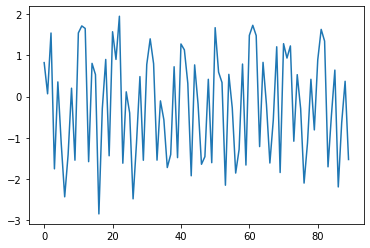

In [104]:
sharpe_ratio_np = np.array(sharpe_ratio_list)

sharpe_ratio_df = pd.DataFrame()
sharpe_ratio_df['sr'] = sharpe_ratio_np

sharpe_ratio_df['sr'].plot()

<AxesSubplot:>

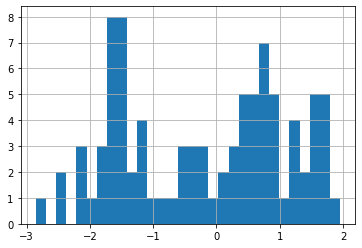

In [105]:
sharpe_ratio_df['sr'].hist(bins=30)

<AxesSubplot:>

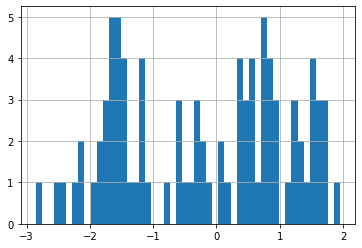

In [106]:
sharpe_ratio_df['sr'].hist(bins=50)

Mean Sharpe Ratio : -0.19018588937134426


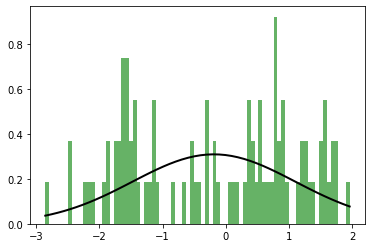

In [107]:
from scipy.stats import norm

fig, axs = plt.subplots(1)

xmin = sharpe_ratio_df['sr'].values.min()
xmax = sharpe_ratio_df['sr'].values.max()
bins = 50

mu, sigma = norm.fit(sharpe_ratio_df['sr'].values)

x = np.linspace(xmin, xmax, bins)
p = norm.pdf(x, mu, sigma)

axs.hist(sharpe_ratio_df['sr'].values, bins=80, density=True, alpha=0.6, color='g')
axs.plot(x, p, 'k', linewidth=2)

print(f"Mean Sharpe Ratio : {mu}")